In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
import torch
import random
from src.model.model_builder import Model
from src.data.dataset_loader import DetectionDataset
from src.data.visualization import visualize_comparison
from src.data.transforms import get_train_transforms, get_val_transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Loading configuration

In [3]:
from src.utils.config_loader import load_config
cfg = load_config("../config.yaml")
data_cfg = cfg['data']
model_cfg = cfg['model']
training_cfg = cfg['training']

## Setting up Dataset

### Setting up the train and val paths 

In [4]:
train_path = os.path.join("..",data_cfg['processed_dir'], data_cfg['train_parquet'])
val_path = os.path.join("..",data_cfg['processed_dir'], data_cfg['val_parquet'])
train_images = "../" + data_cfg['train_images']
val_images = "../" + data_cfg['val_images']

### Loading Dataset

In [5]:
train_dataset = DetectionDataset(train_path, train_images, get_train_transforms())
val_dataset = DetectionDataset(val_path, val_images, get_val_transforms())

[INFO] Using 100.00% of the dataset
[INFO] Loaded parquet file - .././dataset/processed/parquet/train
[INFO] Using 100.00% of the dataset
[INFO] Loaded parquet file - .././dataset/processed/parquet/val


## Model Loading from Checkpoint

In [6]:
# Initialize Model
model = Model(**model_cfg['config'], num_classes=model_cfg['num_classes']).to(device)

# Load Weights
checkpoint_path = "../dataset/experiments/model_epoch_5.pth"
try:
    model.load_weights(checkpoint_path)
    print("Weights loaded successfully!")
except Exception as e:
    print(f"Error loading weights: {e}")

model.eval()

Error loading weights: Error(s) in loading state_dict for Model:
	While copying the parameter named "net.p1.0.conv.weight", whose dimensions in the model are torch.Size([96, 3, 3, 3]) and whose dimensions in the checkpoint are torch.Size([96, 3, 3, 3]), an exception occurred : ('aten.copy_.default: got mixed torch.Tensor and DTensor, need to convert all torch.Tensor to DTensor before calling distributed operators!',).
	While copying the parameter named "net.p1.0.norm.weight", whose dimensions in the model are torch.Size([96]) and whose dimensions in the checkpoint are torch.Size([96]), an exception occurred : ('aten.copy_.default: got mixed torch.Tensor and DTensor, need to convert all torch.Tensor to DTensor before calling distributed operators!',).
	While copying the parameter named "net.p1.0.norm.bias", whose dimensions in the model are torch.Size([96]) and whose dimensions in the checkpoint are torch.Size([96]), an exception occurred : ('aten.copy_.default: got mixed torch.Tensor a

Model(
  (net): Backbone(
    (p1): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (relu): SiLU()
      )
    )
    (p2): Sequential(
      (0): Conv(
        (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (relu): SiLU()
      )
      (1): C3K2(
        (conv1): Conv(
          (conv): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (relu): SiLU()
        )
        (conv2): Conv(
          (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(384, eps=0.001, momentum=0.03, affine=True, track_run

## Prediction

### Using Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Detections found: 1
First detection (xyxy, conf, cls):
tensor([[276.0143,  60.0000, 396.7934,  89.0778, 363.8233, 146.0000],
        [228.0353,  52.0000, 349.3463,  86.5389, 363.5848,  41.0000],
        [284.0135,  76.0000, 404.9330, 104.3635, 361.9202, 146.0000],
        ...,
        [140.2057, 147.9993, 262.3482, 180.4921, 248.4057, 146.0000],
        [-51.9083, 259.9994,  72.1908, 292.5457, 247.9227, 146.0000],
        [468.0216, 491.9995, 593.4794, 519.8828, 247.8745,  41.0000]],
       device='cuda:0')


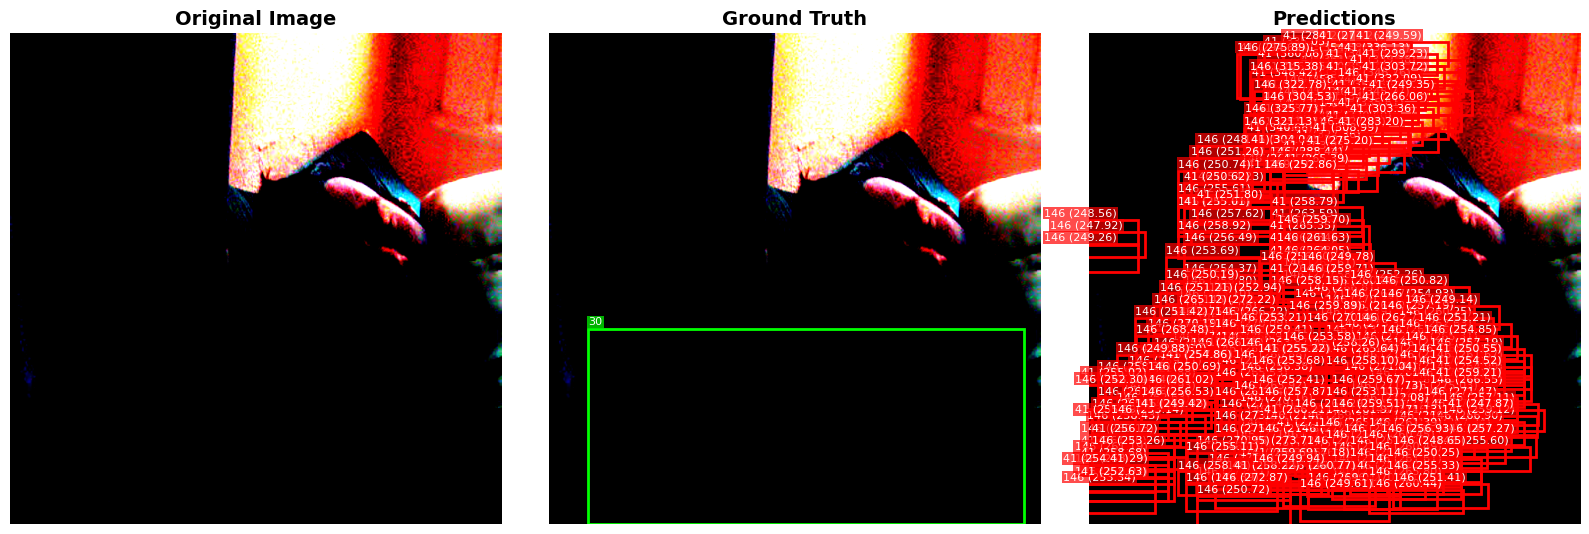

In [7]:
img, target = val_dataset.__getitem__(random.randint(0, val_dataset.__len__()))

# Run Inference
detections = model.inference(img, conf_thres=0.75, iou_thres=0.45)

print(f"Detections found: {len(detections)}")
if len(detections) > 0:
    print("First detection (xyxy, conf, cls):")
    print(detections[0])

visualize_comparison(img, target, detections)

### Using image path

Detections found: 1
First detection (xyxy, conf, cls):
tensor([[340.3211,  83.9991, 462.2292, 120.9990, 284.9119,  41.0000],
        [333.7452,  99.9985, 453.3305, 133.3533, 283.8218,  41.0000],
        [333.9099, 115.9978, 453.6192, 150.8988, 283.1458,  41.0000],
        ...,
        [-56.2678, 403.9680,  63.2776, 439.9792, 178.7070,  41.0000],
        [519.5310, 475.9996, 670.8965, 508.3857, 178.7043,  41.0000],
        [365.7390, 483.8802, 479.5579, 534.8026, 178.5289, 146.0000]],
       device='cuda:0')


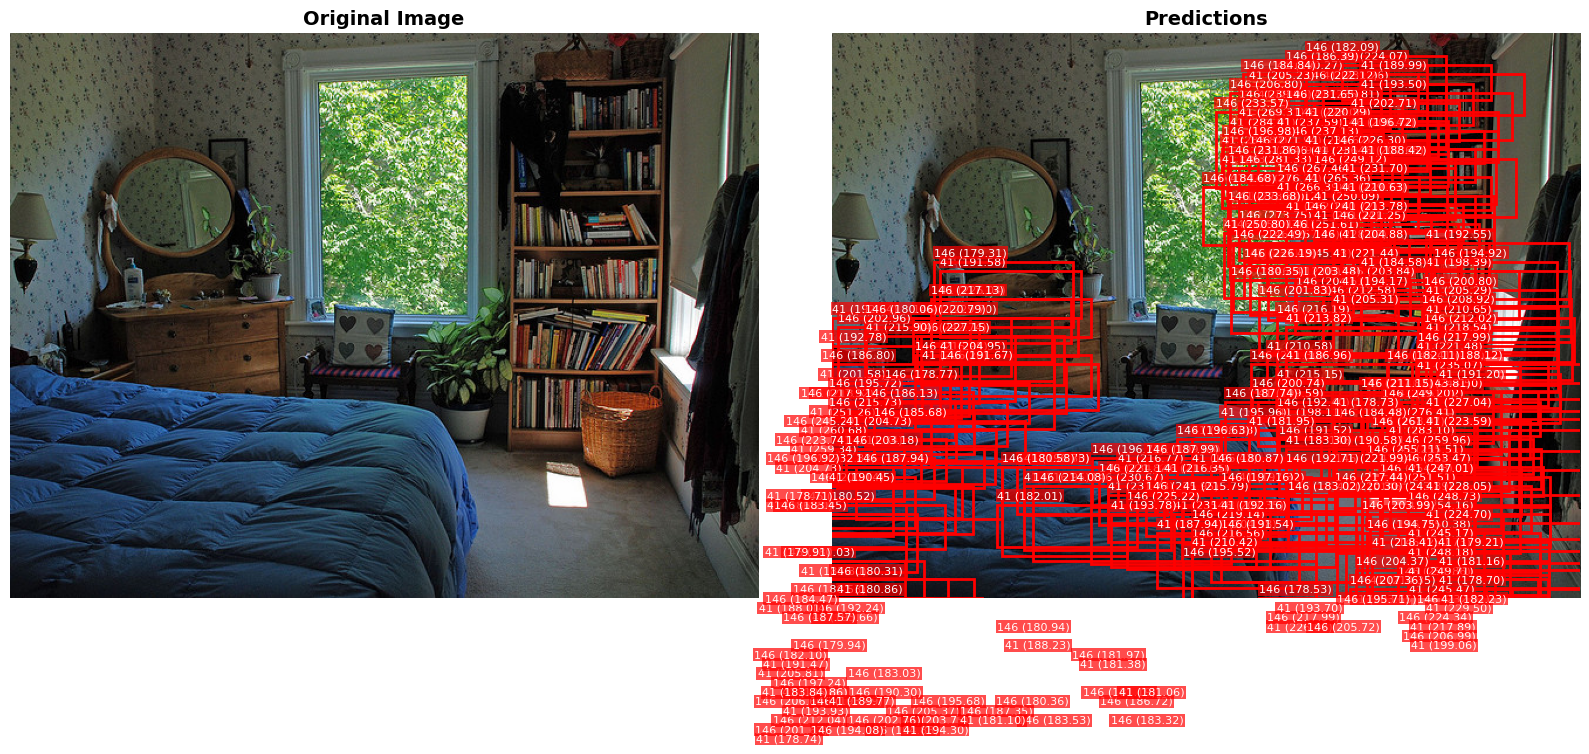

In [8]:
img = "../dataset/raw/images/val/000000000632.jpg"

# Run Inference
detections = model.inference(img, conf_thres=0.75, iou_thres=0.45)

print(f"Detections found: {len(detections)}")
if len(detections) > 0:
    print("First detection (xyxy, conf, cls):")
    print(detections[0])

visualize_comparison(image=img, prediction=detections)